<a href="https://colab.research.google.com/github/zenAurelius/HRAI3/blob/main/notebooks/test_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/HRAI/data

Mounted at /content/drive
/content/drive/MyDrive/HRAI/data


In [2]:
df = pd.read_csv('pmu2016_os.zip')
df.head()

,aid_cr,rfs_date,rfs_heure,ris_nom,rfi_prix,rfi_distance,rfs_corde,rfs_condSexe,rfi_nbPartants,rfs_hippodrome,...,pff_ord_2,OS_D_MU_pis_cheval_1,OS_D_SG_pis_cheval_1,OS_N_MU_pis_cheval_1,OS_N_SG_pis_cheval_1,OS_D_MU_pis_driver_1,OS_D_SG_pis_driver_1,OS_N_MU_pis_driver_1,OS_N_SG_pis_driver_1,pff_pwin_1
0,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
1,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
2,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
3,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
4,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,1.964295,0.981306,26.964295,8.177963,1.964295,0.981306,26.964295,8.177963,0.5


In [3]:
#SELECTION DES FEATURES ET TARGET
#df = df[['rfi_prix','rfi_distance','pfi_chNbPlaces_1','pff_rapportDirect_1','pff_ord_1','pfi_chNbPlaces_2','pff_rapportDirect_2','pff_ord_2','tgf_win_1']].copy()
df = df[['pff_rapportDirect_1','pff_ord_1','pff_rapportDirect_2','pff_ord_2','tgf_win_1']].copy()
df = df[(~df.pff_rapportDirect_2.isna()) & (~df.pff_rapportDirect_1.isna())].copy()
df['diff_cote'] = df.pff_rapportDirect_1 /  (df.pff_rapportDirect_2 + df.pff_rapportDirect_1)
df['diff_ord'] = df.pff_ord_1 /  (df.pff_ord_2 + df.pff_ord_1)
df['tgf_win_1'] = df['tgf_win_1'].replace(0.5, 0)
df = df[['diff_cote','diff_ord', 'tgf_win_1']].copy()
df.head()

,diff_cote,diff_ord,tgf_win_1
0,0.795918,0.5,0.0
1,0.557143,0.5,0.0
2,0.849673,0.5,0.0
3,0.819328,0.5,0.0
4,0.280576,0.5,1.0


In [5]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')


1117404 training examples
139676 validation examples
139676 test examples


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [6]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('tgf_win_1')
  df = {key: np.array(value)[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [7]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [8]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


In [9]:
all_inputs = []
encoded_features = []

# Numerical features.
#for header in ['rfi_prix', 'rfi_distance', 'pfi_chNbPlaces_1', 'pff_rapportDirect_1', 'pff_ord_1', 'pfi_chNbPlaces_2', 'pff_rapportDirect_2', 'pff_ord_2']:
for header in ['diff_cote', 'diff_ord']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [30]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(8, activation="relu")(all_features)
output = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)


In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])


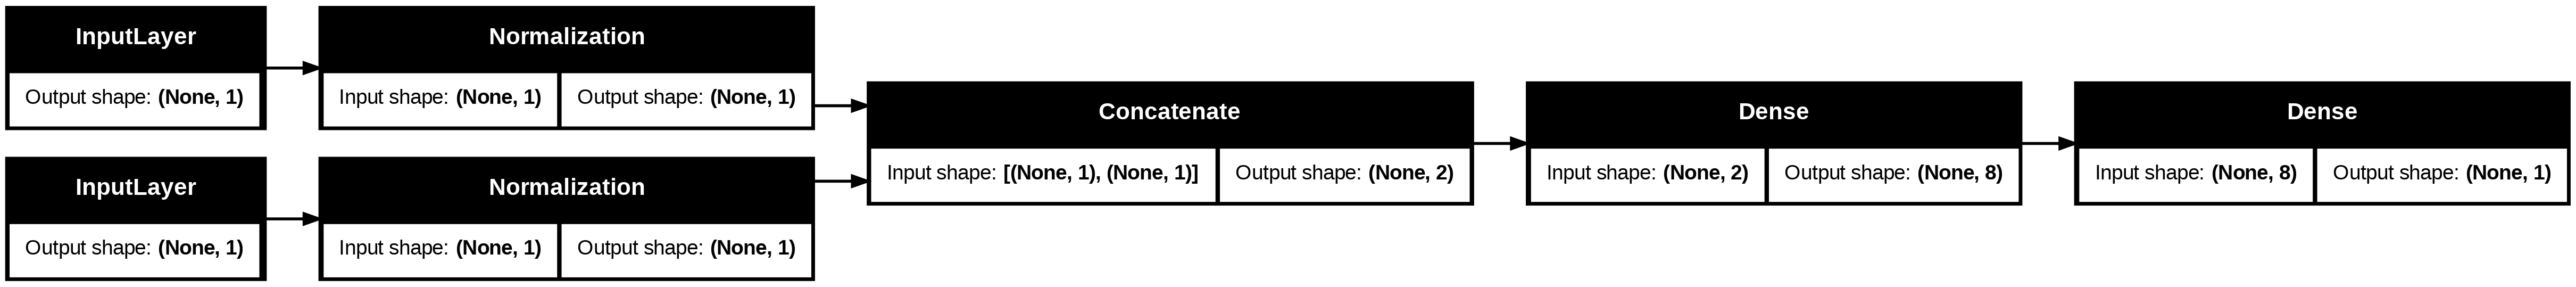

In [32]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [33]:
model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4365/4365 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6168 - loss: 0.6519 - val_accuracy: 0.6314 - val_loss: 0.6428
Epoch 2/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.6304 - loss: 0.6428 - val_accuracy: 0.6316 - val_loss: 0.6423
Epoch 3/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6312 - loss: 0.6422 - val_accuracy: 0.6309 - val_loss: 0.6422
Epoch 4/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.6301 - loss: 0.6423 - val_accuracy: 0.6310 - val_loss: 0.6422
Epoch 5/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.6304 - loss: 0.6424 - val_accuracy: 0.6309 - val_loss: 0.6421
Epoch 6/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.6300 - loss: 0.6423 - val_accuracy: 0.6312 - val_loss: 0.6420
Epoch 7/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.6294 - loss: 0.6428 - val_accuracy: 0.6312 - val_loss: 0.6419
Epoch 8/10
4365/4365 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6306 - loss: 0.6422 - val

In [34]:
model.save('classifier_test.keras')
reloaded_model = tf.keras.models.load_model('classifier_test.keras')

In [35]:
predictions = reloaded_model.predict(test_ds)
predictions

546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0.6517915],
       [0.2782673],
       [0.5797956],
       ...,
       [0.584824 ],
       [0.5021651],
       [0.417833 ]], dtype=float32)

In [37]:
# prompt: je veux mettre le résultat des prédictions dans une colonne 'pred' du dataframe d'origine 'test'

# Convert predictions to a binary classification (e.g., using a threshold)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Add the predictions as a new column 'pred' to the test dataframe
test['pred'] = binary_predictions

# Print the updated dataframe with predictions
test.pred.value_counts()

,count
pred,
0,84055
1,55621


In [17]:
test.tgf_win_1.value_counts()

,count
tgf_win_1,
0.0,76177
1.0,63499


In [38]:
# prompt: dans dataframe 'test' je veux une colonne win_cote qui contient 1 si rapport 2 > rapport 1 et 0 sinon

test['win_cote'] = (test['diff_cote'] < 0.5).astype(int)
test['win_ord'] = (test['diff_ord'] > 0.5).astype(int)

In [39]:
test

,diff_cote,diff_ord,tgf_win_1,pred,win_cote,win_ord
1307202,0.130435,0.680025,1.0,1,1,1
545642,0.873786,0.315881,0.0,0,0,0
474746,0.227642,0.497995,0.0,1,1,0
788409,0.411765,0.437304,0.0,0,1,0
224899,0.727273,0.354621,1.0,0,0,0
...,...,...,...,...,...,...
224359,0.160839,0.587040,1.0,1,1,1
808345,0.722222,0.540763,1.0,0,0,1
586845,0.217054,0.478931,1.0,1,1,0
999082,0.385714,-0.467524,0.0,1,1,0


In [45]:
print(len(test[(test.pred == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))
print(len(test[(test.win_cote == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))
print(len(test[(test.win_ord == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))
print(len(test[(test.win_cote == 1) & (test.win_ord == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))

0.530780012283658
0.6314430148506276
0.590340005354415
0.44107781224901177


In [43]:
print(len(test[(test.pred == 0) & (test.tgf_win_1 == 0)]) / len(test[(test.tgf_win_1 == 0)]))
print(len(test[(test.win_cote == 0) & (test.tgf_win_1 == 0)]) / len(test[(test.tgf_win_1 == 0)]))
print(len(test[(test.win_ord == 0) & (test.tgf_win_1 == 0)]) / len(test[(test.tgf_win_1 == 0)]))

0.7122884860259658
0.6180736967851189
0.5823542539086601


In [47]:
print(len(test[(test.pred == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.pred == 1)]))
print(len(test[(test.win_cote == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.win_cote == 1)]))
print(len(test[(test.win_ord == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.win_ord == 1)]))
print(len(test[(test.win_cote == 1) & (test.win_ord == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.win_cote == 1) & (test.win_ord == 1)]))
print(len(test[(test.win_cote == 0) & (test.pred == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.win_cote == 0) & (test.pred == 1)]))

0.6059581812624728
0.5795057089174737
0.5409157155019408
0.6143183014563959
0.5714285714285714
